In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchsummary
import torchsummary
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 7.0 MB/s 


## Carga de datos

In [3]:
class SinteticDataset(torch.utils.data.Dataset):
    def __init__(self):
      self.x = np.linspace(0, 4, 10000).reshape(-1, 1)
      self.y = -(self.x - 2)**2 + 3 + 0.2 * np.sin(16 * self.x)

    def __getitem__(self,index):
      if torch.is_tensor(index):
        index = index.tolist()

      return torch.tensor(self.x[index]).float(), torch.tensor(self.y[index]).float()
    def __len__(self):
      return len(self.x)


In [4]:
train_data = SinteticDataset()

In [5]:
valid_set_size = 1000
train_set, valid_set = torch.utils.data.random_split(train_data, [len(train_data) - valid_set_size, valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))

Tamaño del conjunto de entrenamiento: 9000
Tamaño del conjunto de validación: 1000


In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

In [7]:
xs, ys = next(iter(train_loader))
print(xs.shape)
print(ys.shape)
print(xs[:, 0])
print(ys[:, 0])

torch.Size([32, 1])
torch.Size([32, 1])
tensor([1.0429, 3.2931, 1.9886, 2.0250, 1.2557, 0.6405, 2.3290, 1.2393, 3.6364,
        0.3504, 3.3319, 1.4525, 2.9023, 3.5624, 1.1553, 1.5186, 0.8957, 3.7772,
        0.7317, 3.8304, 3.6264, 3.1543, 1.9206, 1.5786, 3.7300, 0.5393, 3.1503,
        3.0411, 3.8832, 0.7449, 3.8796, 0.2768])
tensor([ 1.9180,  1.4592,  3.0781,  3.1659,  2.6353,  1.0051,  2.8075,  2.5874,
         0.5219,  0.1538,  1.2452,  2.5105,  2.3128,  0.6459,  2.2152,  2.6198,
         1.9768, -0.2939,  1.2398, -0.5502,  0.5540,  1.7080,  2.8669,  2.8472,
         0.0093,  1.0092,  1.7046,  1.7162, -0.6754,  1.3039, -0.6704, -0.1614])


In [8]:
xs, ys = next(iter(valid_loader))
print(xs.shape)
print(ys.shape)
print(xs[:, 0])
print(ys[:, 0])

torch.Size([32, 1])
torch.Size([32, 1])
tensor([2.8323, 2.2038, 1.2417, 1.8654, 0.1892, 2.9571, 0.7349, 2.3390, 0.5869,
        2.2246, 3.5824, 0.6373, 3.3643, 2.7055, 0.4808, 0.8245, 3.7384, 2.4462,
        3.7880, 2.6007, 2.9643, 2.8995, 2.3550, 3.4027, 3.7156, 1.2845, 0.3988,
        0.5677, 0.7849, 0.7365, 1.0421, 0.1172])
tensor([ 2.5017,  2.8291,  2.5952,  2.7819, -0.2562,  2.0463,  1.2548,  2.8308,
         1.0100,  2.7774,  0.6352,  1.0035,  1.0566,  2.3743,  0.8896,  1.7352,
        -0.0466,  2.9992, -0.3557,  2.5000,  2.0101,  2.3246,  2.8702,  0.8602,
         0.1046,  2.6864,  0.4559,  1.0155,  1.5218,  1.2624,  1.9179, -0.3541])


## Modelo 

In [9]:
class NNmodel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features=1, out_features=32)
        self.fc2 = torch.nn.Linear(in_features=32, out_features=16)
        self.fc3 = torch.nn.Linear(in_features=16, out_features=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = NNmodel()

In [10]:
torchsummary.summary(model, input_size=(1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]              64
            Linear-2                [-1, 1, 16]             528
            Linear-3                 [-1, 1, 1]              17
Total params: 609
Trainable params: 609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [11]:
optimizer_ft = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()


def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    mse_metric = torchmetrics.MeanSquaredError()

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = mse_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += mse_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train MSE {:.6f} - Valid Loss {:.6f} - Valid MSE {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [12]:
result_model, history = train(model, criterion, optimizer_ft, train_loader, valid_loader, 50)

Epoch: 1/50 - Train loss 3.273614 - Train MSE 3.273614 - Valid Loss 2.527479 - Valid MSE 2.527479
Epoch: 2/50 - Train loss 2.156498 - Train MSE 2.156498 - Valid Loss 1.861854 - Valid MSE 1.861854
Epoch: 3/50 - Train loss 1.765588 - Train MSE 1.765588 - Valid Loss 1.629438 - Valid MSE 1.629438
Epoch: 4/50 - Train loss 1.609624 - Train MSE 1.609624 - Valid Loss 1.500506 - Valid MSE 1.500506
Epoch: 5/50 - Train loss 1.506170 - Train MSE 1.506170 - Valid Loss 1.407225 - Valid MSE 1.407225
Epoch: 6/50 - Train loss 1.407039 - Train MSE 1.407039 - Valid Loss 1.311558 - Valid MSE 1.311558
Epoch: 7/50 - Train loss 1.296228 - Train MSE 1.296228 - Valid Loss 1.194255 - Valid MSE 1.194255
Epoch: 8/50 - Train loss 1.169181 - Train MSE 1.169181 - Valid Loss 1.071136 - Valid MSE 1.071136
Epoch: 9/50 - Train loss 1.019748 - Train MSE 1.019748 - Valid Loss 0.907753 - Valid MSE 0.907753
Epoch: 10/50 - Train loss 0.865362 - Train MSE 0.865362 - Valid Loss 0.801415 - Valid MSE 0.801415
Epoch: 11/50 - Trai

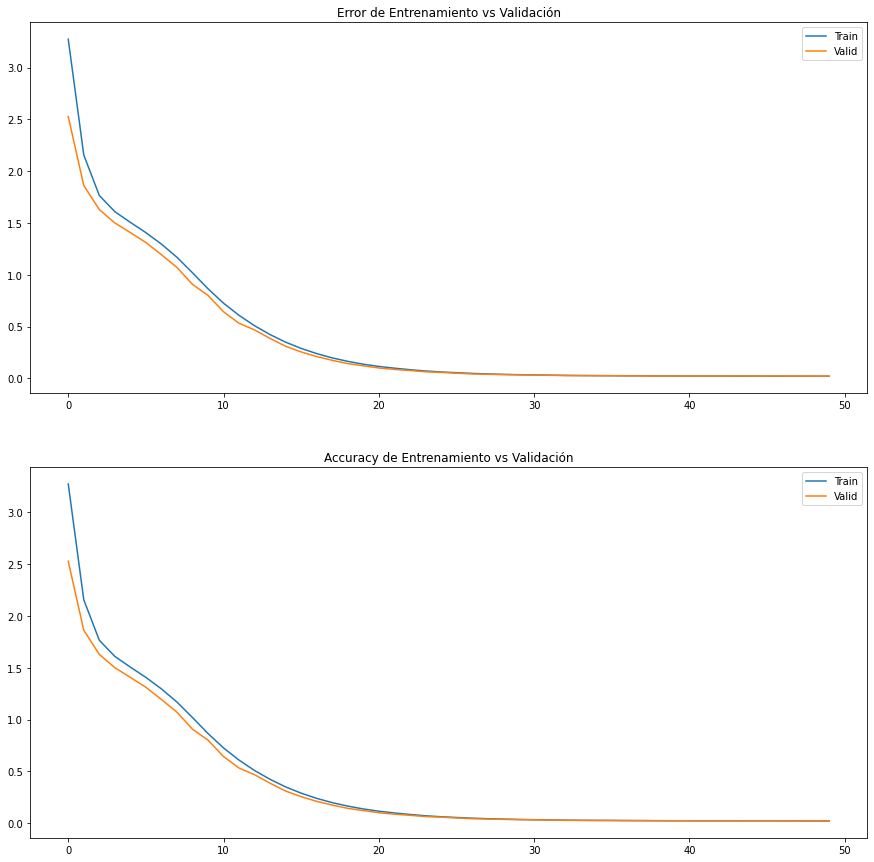

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [14]:
pred = model(torch.tensor(train_data.x).float())
pred = pred.detach().numpy()

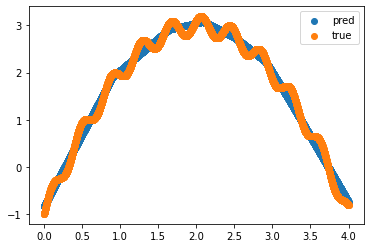

In [15]:

plt.scatter(train_data.x, pred, label='pred')
plt.scatter(train_data.x, train_data.y, label='true')
plt.legend()
plt.show()